# Optimization Methods

In this section we will discuss optimization methods for machine learning. The optimization is the "learning" step in machine learning. There we fit the model to out data, eg. in neural network we will change weights, in linear regression we will change slope and intercept of the model by minimizing a loss function.

The content is only an overview about the optimization techniques and for further reading please look at

["Introduction to Stochastic Search and Optimization"](https://printkr.hs-niederrhein.de:2173/doi/pdfdirect/10.1002/0471722138)  

by James C. Spall {cite}```Spall2003``` and

["Algorithms for Optimization"](https://algorithmsbook.com/optimization/files/optimization.pdf)  

by Mykel J. Kochenderfer and Tim A. Wheele {cite}```Kochenderfer2019```.



## Introduction: an easy example

We want to make a simple linear regression on given data below. For that we want to fit the parameter $\beta_0$ and $ \beta_1$ from the linear regession

$$y_i:=f(x_i)= \beta_0+\beta_1x_i $$

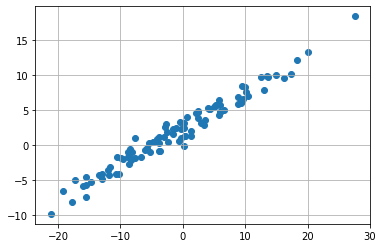

In [37]:
#import numpy as np
import autograd.numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm

x = scipy.stats.norm.rvs(size=100)*10 # Data generation
y = 2.5 + 0.5 * x + scipy.stats.norm.rvs(size=100)

plt.scatter(x,y)
plt.grid()

We now make initial guess for parameters $\beta_0=1$ and $\beta_1 =1$ and see how our model performs. 

For that we need some measure how "good" our fit was. We calculate the difference of each point to our line and we want no negative value so we square the difference of these.

We will then get the **Residual Sum of Squares** (RSS):

$$RSS(\beta_0,\beta_1):=\sum_{i=1}^n(y_p-y)^2$$

Where $y_p$ is the prediction of our model and $y$ is the real data.


RSS of initial guess:  2626.6082452431856


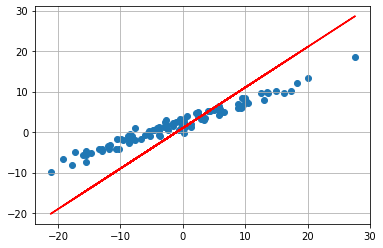

In [38]:
def RSS(beta):
    y_p = beta[0] + beta[1]*x
    return np.sum((y_p-y)**2)

beta0,beta1 = 1,1 #define initial guess

plt.scatter(x,y)
plt.grid()
y_p = beta0 + beta1*x
plt.plot(x,y_p,"r")

print("RSS of initial guess: ",RSS(np.array([beta0,beta1])))

We now see that our initial guess is not good at all. But we can now use the RSS to fit our function to the data. We are searching for a minimum of the RSS function. The coeficents which fits our data best are

$$(\beta_0^*\beta_1^*)=\underset{\beta_0,\beta_1}{\text{argmin}}(RSS)$$



For this we can use the given solution in OLS section of the book. We could also use for example newton's method to solve this for us. Luckily `scipy.opimize.minimize` has a software for us.

RSS of optimum:  93.7647191421149


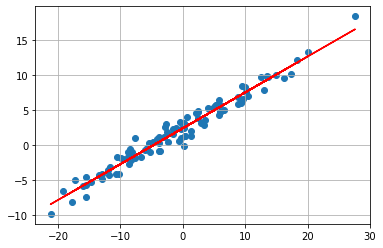

In [39]:
iters = []
start = np.array([1,1,RSS(np.array([1,1]))])
iters.append(start)
def callbackF(Xi):
    iterations = np.append(Xi,RSS(Xi))
    iters.append(iterations)

opt = scipy.optimize.minimize(RSS, x0=np.array([1,1]), args=(), method='TNC', callback=callbackF) #optimize using scipy implementation of truncated newton's method
iters= np.asarray(iters)

plt.scatter(x,y)
plt.grid()
y_p = opt.x[0] + opt.x[1]*x
plt.plot(x,y_p,"r")

print("RSS of optimum: ",RSS(np.array([opt.x[0],opt.x[1]])))

We now see that the "fit" of our model is much better. This method above falls under the category gradient-based optimization. However Newton's method is not often used in machine learning because we need the second derivative, because we are searching the zeros of the first derivative. But often this is not possible or it is just to resource consuming to use it. For the newton's method we need to calculate a inverse of the hessian matrix to get better convergence than first order gradient descent methods.

Now let us take a look on what happend to the RSS function in our optimization algorithm. The next plot shows the start value and the iteration of the algorithm to find a minimum with the help of the gradient. 

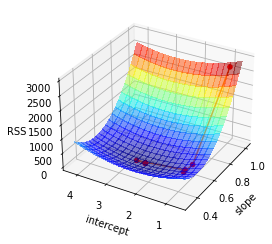

<Figure size 864x720 with 0 Axes>

In [40]:
intercept = opt.x[0]
slope = opt.x[1]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25) #slope
X = np.linspace(slope-0.2, slope+0.5, 20)
Y = np.arange(-5, 5, 0.25) #intercept
Y = np.linspace(intercept-1.8, intercept+1.8, 20)

rss_values_all = []
for slope_alt in np.linspace(slope-0.2, slope+0.5, 20):
    rss_values_x = []
    for intercept_alt in np.linspace(intercept-1.8, intercept+1.8, 20):
        rss_values_x.append(RSS(np.array([intercept_alt,slope_alt])))
    rss_values_all =  np.append(rss_values_all,rss_values_x,axis=0)

plt.figure(figsize=(12,10))
X, Y = np.meshgrid(X, Y)
Z = rss_values_all.reshape(20,20).T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0.5, antialiased=False, cmap='jet', alpha=0.5)
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.set_zlabel('RSS')
dots = ax.scatter3D(iters[:,1], iters[:,0], iters[:,2],s=20, c='r', marker='o', alpha=1) # ToDo add order of iterations
lines = ax.plot(iters[:,1], iters[:,0], iters[:,2]) 
_ = ax.view_init(30, 210)

## A formal definition
### Single objective optimization
Consider a map $f: \mathbb{R}^d \rightarrow \mathbb{R}$. The aim of the (single-objective) optimization is finding a combination of input variables $x^* \in \mathbb{R}^d$, that minimize or maximize $f$. In the case of minimization, the following condition holds:

$$ f(x^*) < f(x) $$

for all $x \in \mathbb{R}^d$, where $x \neq x^*$. We neglect the case, where $f$ may exhibit multiple optima for ease of notation.

As such, we denote the minimization problem as

$$ \mathrm{arg}\min_x \,f(x) $$

In the followin, we assume minimization but note that

$$ \mathrm{arg}\min_x \,f(x) = \mathrm{arg}\max_x \,-f(x)$$

Therefore, any further definition for minimization can be trivially extended to maximization problems.



### Constrained optimization
Sometimes, it may be useful to enforce some criteria on the solution of the optimization problem. Specifically, we expect to find $x^* \in \mathbb{S}$ in the *feasible* space $\mathbb{S}$; a subset $\mathbb{S}\subseteq\mathbb{R}^d$ of the variable space $\mathbb{R}^d$. In this case, the optimization problem is denoted as

\begin{align}
\mathrm{arg}\min_x\,& f(x) \\
\mathrm{subject} \, \mathrm{to} \, & x \in \mathbb{S}
\end{align}

The most common definition of the feasible space $\mathbb{S}$ is through using equality and inequality constraints. An equality constraint $h: \mathbb{R}^d \rightarrow \mathbb{R}$ is a map similar to $f$, which defines $\mathbb{S}$ as follows

$$ \mathbb{S}:= \{x \in \mathbb{R}^d | h(x) = 0\} $$

Notice that we could have any other value than $0$ for the equality condition but any such condition can be transformed to the above form buy substracting the left hand side value from both sides.


An inequality condition $g: \mathbb{R}^d \rightarrow \mathbb{R}$ is also a map and the feasible space $\mathbb{S}$ is defined as

$$ \mathbb{S}:= \{x \in \mathbb{R}^d | g(x) \geq 0\} $$

In case both equality and inequality constraints exist or if there are multiple constraints, each of these conditions define $\mathbb{S}$ as

$$ \mathbb{S}:= \{ x \in \mathbb{R}^d | g_1(x) \geq 0, \dots, g_{n_i}(x) \geq 0, h_1(x) =0, \dots, h_{n_e}(x)=0 \} $$

where $n_e$ and $n_i$ are the number of equality and inequality constraints respectively. For a more concise notation, $\mathbb{S}$ is often omitted and only the conditions are used for the notation of a constrained optimization problem
\begin{align}
\mathrm{arg}\min_x\,& f(x) \\
\mathrm{s. t.}\; & g_i(x) \geq 0 \quad \mathrm{for} \, i \in [1, n_i] \\
&h_j(x) =0 \quad \mathrm{for} \, j \in [1, n_e] \\
\end{align}



## Benchmark Problems
In the next part we will look on different optimization algorithms and how they perform on various problems. Not all problems are that easy to solve that we done above. We will take a look on some benchmark problems.

We will look at the Rosenbrock function in 2d

$$f(x,y) = (a-x)^2+b(y-x^2)^2 $$

with usually parameters $a = 1$ and $b =100$. The minimum is at $(1,1)$ with value $0$.

And we will look at the Rastrigin function in 2d

$$f(x,y) = A*n + x^2-A \cos(2\pi x)+y^2-A \cos(2\pi y) $$

with $A=10$ and $n=2$ as we are in 2 dimensions. The minimum is at $(0,0)$ with value $0$.

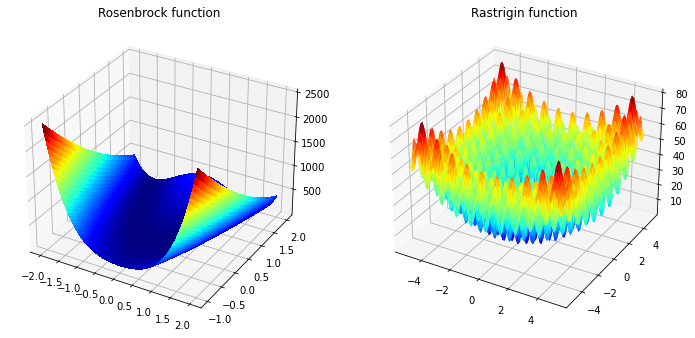

<Figure size 432x288 with 0 Axes>

In [41]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

def Rosenbrock(X):
    Z = 100.0*(X[1] - X[0]**2.0)**2.0 + (1 - X[0])**2.0
    return Z
Z =  Rosenbrock(np.array([X,Y]))

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet',linewidth=0, antialiased=False)
ax.set_title("Rosenbrock function")
#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot rastrigin
X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y)

def Rastrigin(X):
    Z = (X[0]**2 - 10 * np.cos(2 * np.pi * X[0])) + (X[1]**2 - 10 * np.cos(2 * np.pi * X[1])) + 20
    return Z

Z = Rastrigin(np.array([X,Y]))

fig = plt.figure() 
surf2 = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='jet', linewidth=0.08,antialiased=True)   
ax.set_title("Rastrigin function")
plt.show()

The problem with these functions is that we will find a local minima but to find the global minima is difficult. These problems are called non-convex optimization problems.
Rosenbrock functions minimum is at $[1,1]$ and Rastrigin functions minimum is at $[0,0]$

## Gradient Methods
As in our easy example newtons methods is in this category. This requires that the functon is twice differentiable. This is often not the case or to calculate the second derivative is just to time consuming. The gradient descent methods is the easiest method in this case. For this method we the first derivative which is the gradient $\nabla f$. For a one-dimensinal function $f: \mathbb{R} \rightarrow \mathbb{R}$, the gradient $\nabla f(x) \in \mathbb{R}$ can be defined as the following limit

$$\nabla f(x) = \frac{df(x)}{dx} = \lim_{\epsilon \rightarrow 0} \frac{f(x+\epsilon) - f(x)}{(x + \epsilon) - x} = \lim_{\epsilon \rightarrow 0} \frac{f(x+\epsilon) - f(x)}{\epsilon}$$

For a higher dimensional function $f: \mathbb{R}^d \rightarrow \mathbb{R}$, the gradient $\nabla f(x) \in \mathbb{R}^d$ is a $d$-dimensional vector

$$ \nabla f(x) = \begin{pmatrix} \frac{df(x)}{dx_1} \\ 
\frac{df(x)}{dx_2} \\
\vdots \\
\frac{df(x)}{dx_d}\end{pmatrix} $$
where $x = [x_1, x_2, \dots, x_d]$ represent the optimization variables.

Per definition the gradient shows in the direction of the speepest direction. We want find a mininum so will take the negative gradient. Usually in the gradient descent method the gradient is normalized. So the direction of steepest descent is

$$g(x) := -\frac{\nabla f(x)}{|\nabla f(x)|} $$

Now want to move along the steepest direction with a given step size $\alpha$. The step size is often called learning rate in machine learning. We could also find an optimal $\alpha$ to find the minimum along these line (linesearch). The problem here is, that we do not want to overshoot our mininum and we do not want to take too small step size that our search have a lot of iterations.

Our algorithm looks as follows:

$$  x^{(n+1)}:=x^{(n)} + \alpha g(x^{(n)})   $$

where $x^{(n+1)}$ is the next iteration value and $x^{(n)}$ is the current value and $n$ denotes the number of iteration.



Now we will look at an implementation of gradient descent algorithm. As you will notice above we need the first derivative of the function for this method. We could analytically derive the given functions. However, this may be time consuming for more difficult functions. Thus, we prefer a more generalized approach here and use an automatic differentiation algorithm. A package `autograd` is developed for this purpose. Note: This package will only be maintainend but not develop further. A newer implementation called `jax` with more features is the follow up. But for our needs we will stick to `autograd`.

In [42]:
from autograd import grad    
grad_rose = grad(Rosenbrock)       # Obtain its gradient function

def gradient_descent(fun, grad_fun, start_value, max_iters, step_size):
    x_old = start_value 
    alpha = step_size
    hist = []
    start = np.append(start_value, fun(start_value)) #start x,y
    hist.append(start) 
    for i in range(max_iters):
        norm_grad = -(grad_fun(x_old)/abs(grad_fun(x_old))) #normalize gradient
        x_new = x_old+alpha*norm_grad #gradient descent step
        hist.append(np.append(x_new,fun(x_new)))#appending history
        x_old = x_new
    hist= np.asarray(hist)
    return x_new, hist


Rosenbrock
[0.8  0.64]
Rastrigin
[-1.98 -1.  ]


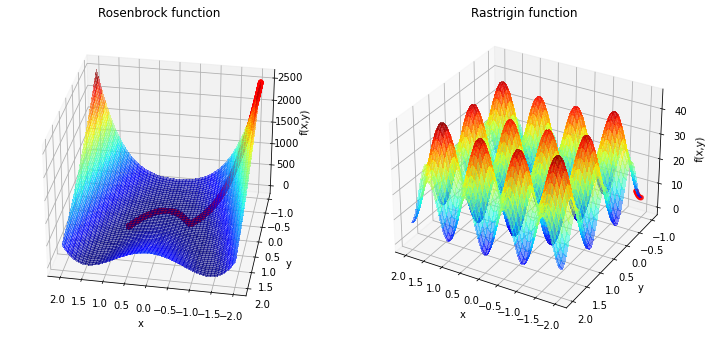

In [43]:
x_end ,hist = gradient_descent(fun=Rosenbrock, grad_fun=grad_rose,start_value=np.array([-2.0,-1.0]),max_iters=20000,step_size=0.0005)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

Z =  Rosenbrock(np.array([X,Y]))

iters=hist

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0.5, antialiased=False, cmap='jet' , alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
dots = ax.scatter3D(iters[:,0], iters[:,1], iters[:,2],s=20, c='r', marker='o') 
lines = ax.plot(iters[:,0], iters[:,1], iters[:,2]) 
ax.view_init(30, 100)
ax.set_title("Rosenbrock function")
print("Rosenbrock")
print(x_end)


ax = fig.add_subplot(1, 2, 2, projection='3d')
grad_rast =  grad(Rastrigin) 
x_end ,hist = gradient_descent(fun=Rastrigin, grad_fun=grad_rast,start_value=np.array([-1.9,-0.9]),max_iters=10,step_size=0.01)

iters= hist

X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

Z =  Rastrigin(np.array([X,Y]))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0.5, antialiased=False, cmap='jet', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
dots = ax.scatter3D(iters[:,0], iters[:,1], iters[:,2],s=20, c='r', marker='o') # ToDo add order of iterations
lines = ax.plot(iters[:,0], iters[:,1], iters[:,2]) 
ax.view_init(30, 120)   
ax.set_title("Rastrigin function")
print("Rastrigin")
print(x_end)
plt.show()


Now we see that we need a lot of iterations for the Rosenbrock function and the minimum is not reached. For the Rastrigin function is clear that pure gradient based approach will not lad to the global minimina at $(0,0)$.
To handle the first problem we can adress some features:
1. it is possible to change the step size over the time.
2. we could apply a momentum to our algorithm, that we accumulate speed in previous steps. We can imagine this as a ball ralling down a hill and become faster.

To handle the second problem we need some kind of mixed method. 

**Momentum**

To avoid the long traverse time in nearly flat surfaces like the rosenbrock function in the valley, we can accumulate speed through momentum.

The momentum update equations are:

$$ 
v^{(n+1)} = \beta v^{(n)} +\alpha g(x^{(n)})  \\
x^{(n+1)} = x^{(n)} + v^{(n+1)}
$$

where $\beta$ is the momentum decay factor and $v$ is the momentum. For $\beta=0$ we get the normal gradiant descent method. This methods increases the speed in narrow flat valley but will also tend to overshoot.

In [44]:
from autograd import grad    
grad_rose = grad(Rosenbrock)       # Obtain its gradient function

def mom_gradient_descent(fun, grad_fun, start_value, max_iters, step_size,beta=0.9):
    x_old = start_value
    momentum_old = 0.0
    #beta = 0.9
    alpha = step_size
    hist = []
    start = np.append(start_value, fun(start_value)) #start x,y
    hist.append(start) 
    for i in range(max_iters):
        norm_grad = -(grad_fun(x_old)/abs(grad_fun(x_old))) #normalize gradient
        momentum_new  = beta*momentum_old+alpha*norm_grad #momentum calculation
        x_new = x_old+momentum_new #gradient descent step
        hist.append(np.append(x_new,fun(x_new)))#appending history
        x_old = x_new
        momentum_old = momentum_new
    hist= np.asarray(hist)
    return x_new, hist

Rosenbrock
[1.0980919 0.9019081]
Rastrigin
[-2. -1.]


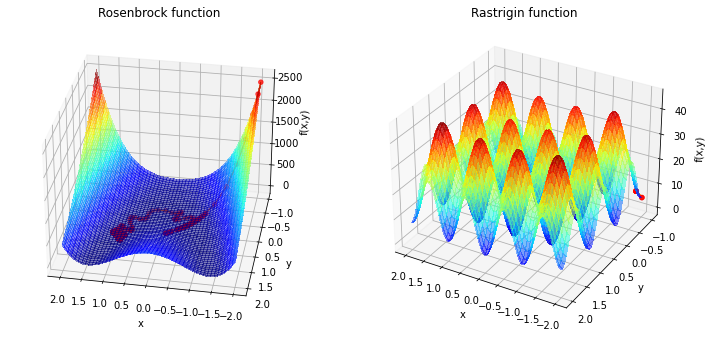

In [45]:
x_end ,hist = mom_gradient_descent(fun=Rosenbrock, grad_fun=grad_rose,start_value=np.array([-2.0,-1.0]),max_iters=2000,step_size=0.05,beta=0.90)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

Z =  Rosenbrock(np.array([X,Y]))

iters=hist

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0.5, antialiased=False, cmap='jet' , alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
dots = ax.scatter3D(iters[:,0], iters[:,1], iters[:,2],s=20, c='r', marker='o') 
lines = ax.plot(iters[:,0], iters[:,1], iters[:,2]) 
ax.view_init(30, 100)
ax.set_title("Rosenbrock function")
print("Rosenbrock")
print(x_end)


ax = fig.add_subplot(1, 2, 2, projection='3d')
grad_rast =  grad(Rastrigin) 
x_end ,hist = mom_gradient_descent(fun=Rastrigin, grad_fun=grad_rast,start_value=np.array([-1.9,-0.9]),max_iters=10,step_size=0.1,beta=1)

iters= hist

X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

Z =  Rastrigin(np.array([X,Y]))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0.5, antialiased=False, cmap='jet', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
dots = ax.scatter3D(iters[:,0], iters[:,1], iters[:,2],s=20, c='r', marker='o') # ToDo add order of iterations
lines = ax.plot(iters[:,0], iters[:,1], iters[:,2]) 
ax.view_init(30, 120)   
ax.set_title("Rastrigin function")
print("Rastrigin")
print(x_end)
plt.show()

Here you can the the oscilation in the left plot. We are a lot faster than before but we tending to overshoot the valley floor. An improvement is Nesterov Momentum, where we use a gradient at a projected future position. Important upgrades from this would be adaptive learning rate which is already implemented in so called **AdaGrad**. One of the most popular algorithms is the adaptive moment estimation method(**ADAM**). **ADAM** includes the exponentially decaying gradient from moment and an exponentially decaying squared gradient like **RMSProp** (which is an improvment of **AdaGrad**). A popular libary for **ADAM** is `Tensorflow`. For more information you can look there or in {cite}```Kochenderfer2019```.



## Stochastic Methods

This chapter gives an overview of some stochastic methods that use randomization strategically to help explore the design space for a minimum. With the help of randomness we can escape local minima and increase the chance of finding a global minimum.

An upgrade for the gradient descent algorithm if it is stuck in a local minimina, is to add noise in each step

$$  x^{(n+1)}:=x^{(n)} + \alpha  g(x^{(n)}) + \epsilon^{(n)} $$

where $\epsilon$ is  a zero-mean Gaussian noise with standard deviation $\sigma$. The noise is typically decrease with increasing iterations.


In [46]:
def stochastic_gradient_descent(fun, grad_fun, start_value, max_iters, step_size, init_noise=1):
    x_old = start_value 
    alpha = step_size
    hist = []
    start = np.append(start_value, fun(start_value)) #start x,y
    hist.append(start) 
    for i in range(max_iters):
        norm_grad = -(grad_fun(x_old)/abs(grad_fun(x_old))) #normalize gradient
        x_new = x_old+alpha*norm_grad+init_noise*np.random.rand(1,2).reshape(2)*1/(i+1) #gradient descent step + noise
        hist.append(np.append(x_new,fun(x_new)))#appending history
        x_old = x_new
    hist= np.asarray(hist)
    return x_new, hist

Rosenbrock
[1.06921554 1.13148882]
Rastrigin
[9.97179242e-01 2.52032571e-04]


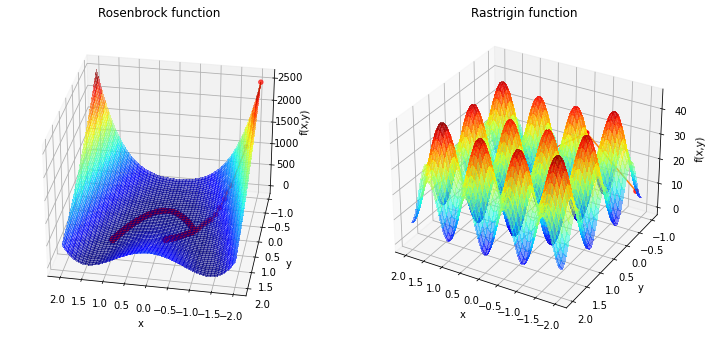

In [47]:
x_end ,hist = stochastic_gradient_descent(fun=Rosenbrock, grad_fun=grad_rose,start_value=np.array([-2.0,-1.0]),max_iters=2000,step_size=0.005)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

Z =  Rosenbrock(np.array([X,Y]))

iters=hist

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0.5, antialiased=False, cmap='jet' , alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
dots = ax.scatter3D(iters[:,0], iters[:,1], iters[:,2],s=20, c='r', marker='o') 
lines = ax.plot(iters[:,0], iters[:,1], iters[:,2]) 
ax.view_init(30, 100)
ax.set_title("Rosenbrock function")
print("Rosenbrock")
print(x_end)


ax = fig.add_subplot(1, 2, 2, projection='3d')
grad_rast =  grad(Rastrigin) 
x_end ,hist = stochastic_gradient_descent(fun=Rastrigin, grad_fun=grad_rast,start_value=np.array([-1.9,-0.9]),max_iters=100,step_size=0.1,init_noise=2)

iters= hist

X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

Z =  Rastrigin(np.array([X,Y]))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0.5, antialiased=False, cmap='jet', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
dots = ax.scatter3D(iters[:,0], iters[:,1], iters[:,2],s=20, c='r', marker='o') # ToDo add order of iterations
lines = ax.plot(iters[:,0], iters[:,1], iters[:,2]) 
ax.view_init(30, 120)   
ax.set_title("Rastrigin function")
print("Rastrigin")
print(x_end)
plt.show()

As you can see, it is possible to get better results with the addition of some noise. Unfortunately it is not garantued to get to the minimum. In the case of the rastrigin function our search path can "jump" around very differently and we have no history which iteration was the best. To improve this furter we could add different starting points to our algorithm. 

## Population Based Methods

Unlike in the previous chapter where a single point moved incrementally to the minimum, in population algorithms we have a lot of points as start points all over the design space which are called individuals. We start with the first genaration of individuals. The best performers of these individuals will make a new generation. This will iterate as long as the minimium is not found. As an example we will show differential evolution. Differential evolution attempts to improve each individual in the population by recombining other individuals in the population according to a simple formula. It is parameterized by a crossover probability $p$ and a differential weight $w$. $w$ is usually between $0.4$ and $1$. For each individual $x$. For More Details look in {cite}```Spall2003```.


Rosenbrock
     fun: 1.9721522630525295e-31
 message: 'Optimization terminated successfully.'
    nfev: 4203
     nit: 139
 success: True
       x: array([1., 1.])
Rastrigin
     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 1953
     nit: 64
 success: True
       x: array([-2.68744538e-09, -3.88047372e-10])


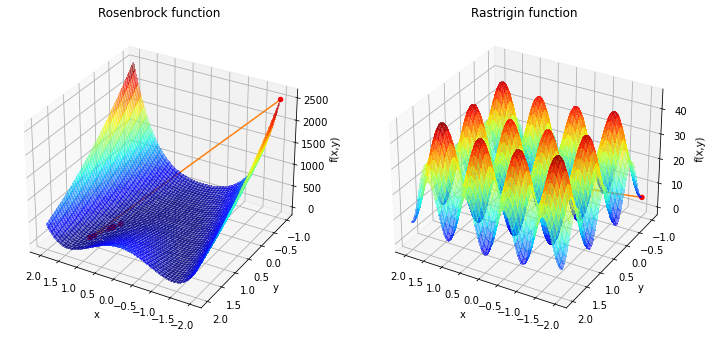

In [48]:
fig = plt.figure(figsize=(12,8))
#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

iters = []
start_vector = np.array([-2,-1])
start = np.append(start_vector,Rosenbrock(start_vector))
iters.append(start)
def callbackRo(Xi, convergence):
    iterations = np.append(Xi,Rosenbrock(Xi))
    iters.append(iterations)


#opt = scipy.optimize.minimize(Rosenbrock, x0=start_vector, args=(), method='CG', callback=callbackRo) #optimize using scipy implementation of truncated newton's method

bounds = [(-2,2), (-1, 2)]
opt = scipy.optimize.differential_evolution(Rosenbrock, bounds, callback=callbackRo)

iters= np.asarray(iters)
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#fig2 =plt.figure("111",figsize=(12,10))
X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

Z =  Rosenbrock(np.array([X,Y]))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0.5, antialiased=False, cmap='jet' , alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
dots = ax.scatter3D(iters[:,0], iters[:,1], iters[:,2],s=20, c='r', marker='o') # ToDo add order of iterations
lines = ax.plot(iters[:,0], iters[:,1], iters[:,2]) 
ax.view_init(30, 120)
ax.set_title("Rosenbrock function")
print("Rosenbrock")
print(opt)
#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

iters = []
start_vector = np.array([-2,-1])
start = np.append(start_vector,Rastrigin(start_vector))
iters.append(start)
def callbackRa(Xi, convergence):
    iterations = np.append(Xi,Rastrigin(Xi))
    iters.append(iterations)

# opt = scipy.optimize.minimize(Rastrigin, x0=start_vector, args=(), method='CG', callback=callbackR) #optimize using scipy implementation of truncated newton's method
bounds = [(-2,2), (-1, 2)]
opt = scipy.optimize.differential_evolution(Rastrigin, bounds, callback=callbackRa)

iters= np.asarray(iters)

X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

Z =  Rastrigin(np.array([X,Y]))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0.5, antialiased=False, cmap='jet', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
dots = ax.scatter3D(iters[:,0], iters[:,1], iters[:,2],s=20, c='r', marker='o') # ToDo add order of iterations
lines = ax.plot(iters[:,0], iters[:,1], iters[:,2]) 
ax.view_init(30, 120)   
ax.set_title("Rastrigin function")
print("Rastrigin")
print(opt)
plt.show()

## References

```{bibliography}
:filter: docname in docnames
:style: plain
```